In [1]:
import numpy as np

from astropy import units as u

from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LogNorm

from astropy.io import fits

from gunagala import imager, psf
from gunagala.utils import ensure_unit

from mocks import mocks

%matplotlib inline
rcParams['figure.figsize'] = (12,8)

The configuration is created in the next cell. I am using `config_example.yaml` file with some small changes (a local file is used as the input and the x axis is chosen as the viewing axis).
There will be more changes to config in the process which will be applied in the proper places.

In [2]:
config = mocks.parse_config(sim_data_path='sim_data/snapshot_201',
                            viewing_axis='x')

### Reading the simulation data:

In [3]:
positions, mass, properties = mocks.read_gadget(config)

/anaconda3/lib/python3.7/site-packages/pynbody-0.47-py3.7-macosx-10.7-x86_64.egg/pynbody/snapshot/gadget.py:464: RuntimeWarning: Run out of block names in the config file. Using fallbacks: UNK*
  "Run out of block names in the config file. Using fallbacks: UNK*", RuntimeWarning)


The third output of the `read_gadget` function is something that might need more thought.

The code makes use of `pynbody` to read the simulation data. It reads all star components (stars, disk and bulge) as a single component (stars). The disk and bulge components are the zoom in data and they have much better resolution comparing to the stars component. 
We are interested in the disk and bulge components so we want to remove the stars component from the data so we use the difference between the mass of those components to remove the stars particles.

## Removing the heavy, low resolution, particles from the data.

The disk and bulge components have mass rate less than 1e8 solar mass and we use that to remove the heavier particles.

In [4]:
selection = np.where(mass < 1e8)

In [5]:
desired_pos = positions[selection]
desired_mass = mass[selection]

In [6]:
print(desired_mass.shape, desired_pos.shape)

(9410212,) (9410212, 3)


The desired part of the data might locates somewhere close to edges of the simulation box, so we plot histograms of the particles in all direction to have an idea about the position of the data.

## Checking the position of particles.

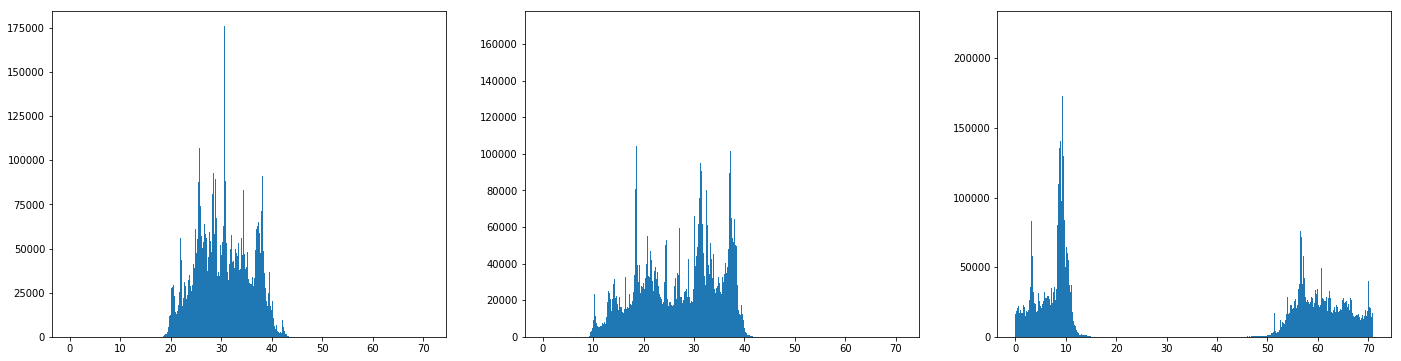

In [24]:
xdges = np.arange(0., 71.001, .1)
fig=plt.figure(figsize=(16, 16))
for i in range(3):
    fig.add_subplot(1, 3, i + 1)
    plt.hist(desired_pos[:, i], bins=xdges)
    plt.gcf().set_size_inches(24, 6)

### Trying to use the median of the histogram to get the data closer to the center of the simulation box.

To do that, I creat the following function and use it to position the data.

In [25]:
def positioning(data, box_size=71., centre=None):
    shape = data.shape
    corrected_data = np.zeros(shape)
    if not centre:
        centre = ((box_size / 2), (box_size / 2))
    for i in range(3):
        med = np.median(data[:, i])
        mod = (box_size / 2) - med
        corrected_data[:, i] = (data[:, i] + mod) % box_size 
    return corrected_data
        

In [26]:
corrected_data = positioning(desired_pos)

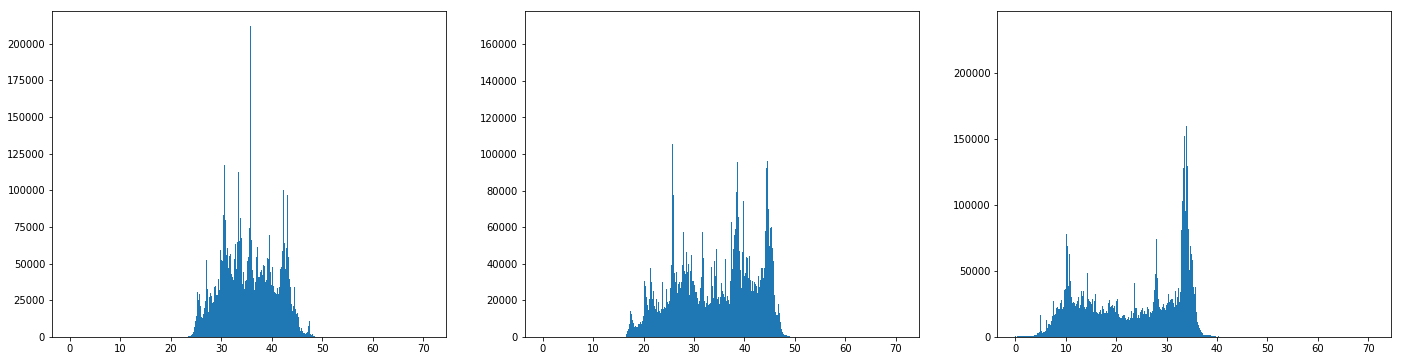

In [27]:
fig=plt.figure(figsize=(16, 16))
for i in range(3):
    fig.add_subplot(1, 3, i + 1)
    plt.hist(corrected_data[:, i], bins=xdges)
    plt.gcf().set_size_inches(24, 6)

## Finding the most dense position in all directions.

This might be removed when we have the final version of data.

We use histogram of the data in each direction to find the most dense positon. The resulotion of the histogram is the same as the plots above (100 kpc).

In [28]:
z_axis, z = np.histogram(corrected_data[:,0],
                         bins=xdges,
                         weights=desired_mass)

In [29]:
y_axis, z = np.histogram(corrected_data[:,1],
                         bins=xdges,
                         weights=desired_mass)

In [30]:
x_axis, z = np.histogram(corrected_data[:,2],
                         bins=xdges,
                         weights=desired_mass)

In [31]:
print(np.argmax(z_axis) / 10, np.argmax(y_axis) / 10, np.argmax(x_axis) / 10)

35.7 25.8 34.0


The above indicate the position of the most dense 100 kpc box in the simulation box.
x axis is considered as the viewing axis in the configuration. Thereby we should put the value of `target_galaxy_comoving_depth` equal to 34.0 Mpc in the configuration.

In [32]:
config['target_galaxy_comoving_depth'] = 34.0 * u.Mpc

### Cutting the dense box:

In [34]:
pos, mss = mocks.cut_data(corrected_data,
                          desired_mass,
                          z_range=[35.69, 35.80] * u.Mpc,
                          y_range=[25.78, 25.89] * u.Mpc,
                          x_range=[0, 71.] * u.Mpc)

### Converting the mass of particles to light

We use the mass to light ratio, in g band, which is provided by user to convert the mass to the light.

In [35]:
config['mass_to_light_ratio']['g'] = ensure_unit(config['mass_to_light_ratio']['g'],
                                                 u.M_sun / u.L_sun)
mss = ensure_unit(mss, u.M_sun)

In [36]:
light = mss / config['mass_to_light_ratio']['g']

## Creating a simple projected image from the data.

In [56]:
zz = np.arange(35.69, 35.8001, .001)
yy = np.arange(25.78, 25.8901, .001)

The resolution of the image is 1 kpc per pixel.

In [57]:
prim, z, y = np.histogram2d(pos[:, 0],
                            pos[:, 1],
                            bins=(zz, yy),
                            weights=light)

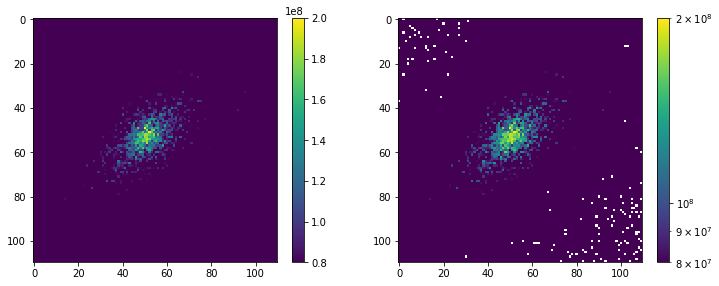

In [119]:
plt.subplot(1,2,1)
plt.imshow(prim, vmin=8e7, vmax=2e8)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(prim, norm=LogNorm(), vmin=8e7, vmax=2e8)
plt.colorbar()
plt.gcf().set_size_inches(12, 4.5)

In [63]:
light.sum()

<Quantity 4.05673511e+11 solLum>

In [69]:
prim.sum()

405673511388.0

## Creating a scaled projected image from the data.

In [64]:
pos, light = mocks.scale_light_by_distance(pos,
                                         light,
                                         config)

In [65]:
light.sum()

<Quantity 4.15143044e+11 solLum>

In [66]:
scaled, z, y = np.histogram2d(pos[:, 0],
                            pos[:, 1],
                            bins=(zz, yy),
                            weights=light)

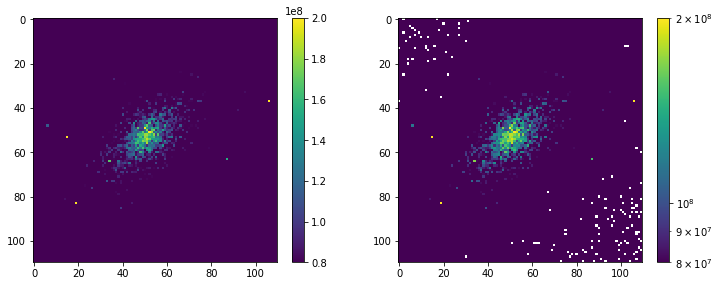

In [118]:
plt.subplot(1,2,1)
plt.imshow(scaled, vmin=8e7, vmax=2e8)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(scaled, norm=LogNorm(), vmin=8e7, vmax=2e8)
plt.colorbar()
plt.gcf().set_size_inches(12, 4.5)

In [68]:
scaled.sum()

415143043684.9404

### Computing pixel scale

This should be adressed in a new function.

In [71]:
cosmo = mocks.create_cosmology(config)

In [73]:
z = mocks.compute_redshift(config['galaxy_distance'],
                           cosmo)
print(config['galaxy_distance'], z)

10.0 Mpc 0.00230742076238339


In [76]:
config['sim_pc_pixel'] = 1000 * u.pc / u.pixel

In [77]:
config['pixel_scale'] = mocks.compute_pixel_scale(z,
                                                  cosmo,
                                                  config['sim_pc_pixel'])
config['pixel_scale']

<Quantity 20.72177831 arcsec / pix>

#### The function `compute_apparent_ABmag` needs to be updated. The following is doing what it supposed to do.

In [78]:
total_lum = light.sum()
total_lum

<Quantity 4.15143044e+11 solLum>

In [79]:
absolute_ABmag = (config['abs_mag_sun']['g'] - 2.5 * np.log10(total_lum.value)) * u.ABmag
absolute_ABmag

<Magnitude -23.93549441 mag(AB)>

In [80]:
distance_modulus = cosmo.distmod(z)
distance_modulus

<Quantity 30.00000001 mag>

In [81]:
apparent_ABmag = absolute_ABmag + distance_modulus
apparent_ABmag

<Magnitude 6.0645056 mag(AB)>

In [83]:
config['total_mag'] = apparent_ABmag

## Creating imager:

In [84]:
imagers = imager.create_imagers()
huntsman = imagers['canon_sbig_dark']

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


### Noiseless image:

In [85]:
noiseless = mocks.create_mock_galaxy_noiseless_image(config,
                                                     scaled,
                                                     huntsman,
                                                     oversampling=1)

/Users/45028222/gunagala/gunagala/psf.py:417: UserWarning: Warning: below zero values in resampled PSF. Clipping to zero.
  warn("Warning: below zero values in resampled PSF. Clipping to zero.")
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


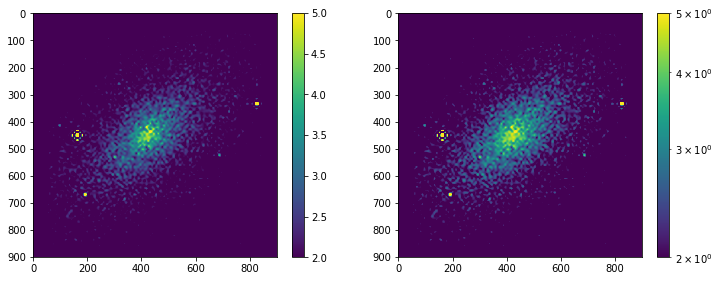

In [117]:
plt.subplot(1,2,1)
plt.imshow(noiseless[1200:2100, 800:1700], vmin=2, vmax=5)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(noiseless[1200:2100, 800:1700], norm=LogNorm(), vmin=2, vmax=5)
plt.colorbar()
plt.gcf().set_size_inches(12, 4.5)

# The ring problem in `gunagala` appeared in the above imges again!

It seems that the bright pixels are some particles closer to the observer and as a result of scaling light by distance, the are such luminous.

In [89]:
noiseless.data.max()

163.30972767793097

In [99]:
np.argmax(noiseless.data)

1243.255261575466

In [98]:
noiseless.data.shape

(3326, 2504)

### Convolve the noiseless image:

In [100]:
psf_data = huntsman.psf.pixellated()

In [101]:
convolved = mocks.convolve_image_psf(noiseless,
                                    psf_data,
                                    convolution_boundary='extend')

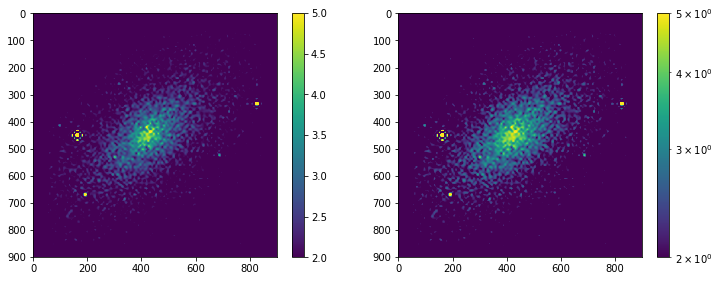

In [116]:
plt.subplot(1,2,1)
plt.imshow(convolved[1200:2100, 800:1700], vmin=2, vmax=5)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(convolved[1200:2100, 800:1700], norm=LogNorm(), vmin=2, vmax=5)
plt.colorbar()
plt.gcf().set_size_inches(12, 4.5)

### Creating noisy images and stack them:

The following cell has done inside the `create_mock_galaxy_noiseless_image` once. Maybe that function should divide to two functions to prevent repeating this

In [104]:
galaxy_psf = psf.PixellatedPSF(scaled,
                               psf_sampling=config['pixel_scale'],
                               oversampling=1)
huntsman_galaxy = imager.Imager(optic=huntsman.optic,
                        camera=huntsman.camera,
                        filters=huntsman.filters,
                        psf=galaxy_psf,
                        sky=huntsman.sky)

In [105]:
stacked = mocks.mock_image_stack(convolved, huntsman_galaxy, n_exposures=100)

Stacking  100  images took 382.35347509384155 to run


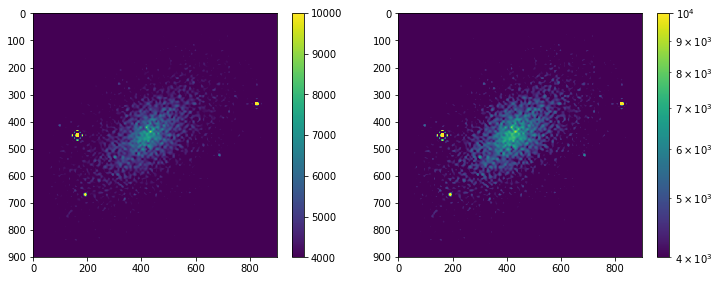

In [115]:
plt.subplot(1,2,1)
plt.imshow(stacked[1200:2100, 800:1700], vmin=4e3, vmax=1e4)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(stacked[1200:2100, 800:1700], norm=LogNorm(), vmin=4e3, vmax=1e4)
plt.colorbar()
plt.gcf().set_size_inches(12, 4.5)